In [73]:
import open3d as o3d
import numpy as np
import math
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import math

In [2]:
pcd = o3d.io.read_point_cloud("data/test_capture.ply")
axes = o3d.geometry.TriangleMesh.create_coordinate_frame()

In [3]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=10000)

[a, b, c, d] = plane_model
pcd = pcd.translate((0,0,d/c))
axes = o3d.geometry.TriangleMesh.create_coordinate_frame()

plane_pcd = pcd.select_by_index(inliers)
plane_pcd.paint_uniform_color([1.0, 0, 0])
stockpile_pcd = pcd.select_by_index(inliers, invert=True)
stockpile_pcd.paint_uniform_color([0, 0, 1.0])

PointCloud with 14893 points.

In [4]:
cos_theta = c / math.sqrt(a**2 + b**2 + c**2)
sin_theta = math.sqrt((a**2+b**2)/(a**2 + b**2 + c**2))
u_1 = b / math.sqrt(a**2 + b**2 )
u_2 = -a / math.sqrt(a**2 + b**2)

rotation_matrix = np.array([[cos_theta + u_1**2 * (1-cos_theta), u_1*u_2*(1-cos_theta), u_2*sin_theta],
                            [u_1*u_2*(1-cos_theta), cos_theta + u_2**2*(1- cos_theta), -u_1*sin_theta],
                            [-u_2*sin_theta, u_1*sin_theta, cos_theta]])

plane_pcd.rotate(rotation_matrix)
stockpile_pcd.rotate(rotation_matrix)
o3d.visualization.draw_geometries([plane_pcd, stockpile_pcd, axes])

In [5]:
cl, ind = stockpile_pcd.remove_statistical_outlier(nb_neighbors=30,
                                                    std_ratio=2.0)
stockpile_pcd = stockpile_pcd.select_by_index(ind)
o3d.visualization.draw_geometries([stockpile_pcd, axes])

In [6]:
downpdc = stockpile_pcd.voxel_down_sample(voxel_size=0.05)
xyz = np.asarray(downpdc.points)
xy_to_z = {}
xy_catalog = []
for point in xyz:
    xy_catalog.append([point[0], point[1]])
    xy_to_z[(point[0], point[1])] = point[2]

tri = Delaunay(np.array(xy_catalog))


In [8]:
surface = o3d.geometry.TriangleMesh()
surface.vertices = o3d.utility.Vector3dVector(xyz)
surface.triangles = o3d.utility.Vector3iVector(tri.simplices)
o3d.visualization.draw_geometries([surface], mesh_show_wireframe=True)

In [93]:
def get_triangles_vertices(triangles, verices):
    triangles_vertices = []
    for triangle in triangles:
        new_triangles_vertices = [vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]]
        triangles_vertices.append(new_triangles_vertices)
    return np.array(triangles_vertices)

In [87]:
def volume_under_triangle(triangle):
    p1, p2, p3 = triangle
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    x3, y3, z3 = p3
    return abs((z1+z2+z3)*(x1*y2-x2*y1+x2*y3-x3*y2+x3*y1-x1*y3)/6)

test = volume_under_triangle([[0,0,1], [0,1,1], [1,0,1]])
print(test)

0.5


In [78]:
volume = 0
for triangle_vertices in triangles_vertices:
    volume += volume_under_triangle(triangle_vertices)

print(volume)

0.009889658588769657


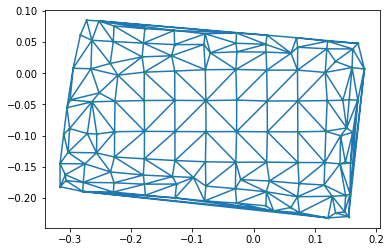

In [12]:
plt.triplot(xyz[:,0], xyz[:,1], tri.simplices)
plt.plot(xyz[:,0], xyz[:,1], 'o', markersize=1)
plt.show()

In [13]:
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(surface)
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(hull_ls)
vis.update_geometry(hull_ls)
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image("wiremesh.png")
vis.destroy_window()

In [95]:
mesh = o3d.io.read_triangle_mesh('data/bun_zipper.ply')
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])
np.asarray(mesh.triangles).shape

(69451, 3)

In [102]:
volume = 0
count = 0
print(get_triangles_vertices(mesh.triangles, mesh.vertices).shape)
for triangle_vertices in []:
    volume += volume_under_triangle(triangle_vertices)
    count +=1

print(count)
print(volume)

(232, 3, 3)
0
0
